In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath

from torch import Tensor

import dateutil.parser as dparser

import sys
import os

import seaborn as sns

/home/joel/project/aintelope/venv_aintelope/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = os.path.split(os.path.split(os.getcwd())[0])[0]

if root_dir not in sys.path:
    sys.path.append(root_dir)

In [3]:
experiment_dir = root_dir+'/outputs/lightning_logs/experiment/' # these might change over time
record_folder = experiment_dir+'memory_records/'
available_records = os.listdir(record_folder)
print(available_records)

files = [os.path.join(record_folder, f) for f in available_records] # add path to each file
files.sort(key=lambda x: os.path.getmtime(x))

latest_file = files[-1]
print(latest_file)
print(dparser.parse(latest_file,fuzzy=True))
df = pd.read_csv(latest_file)
print(df.columns)

['20230911151334.csv', '20230908191722.csv', '20230908183606.csv', '20230911140234.csv', '20230911142110.csv', '20230911144239.csv', '20230908104718.csv', '20230905135142.csv', '20230911140547.csv', '20230911143722.csv']
/home/joel/project/aintelope/outputs/lightning_logs/experiment/memory_records/20230911151334.csv
2023-09-11 15:13:34
Index(['state', 'action', 'reward', 'done', 'instinct_events', 'new_state'], dtype='object')


In [4]:
%%capture
'''
WIP, plot what the agent sees (needs changes to InferenceAgent etc.)
Check action values per location. Now expected reward for moving into location, but could also be
eating in any location, or of course mapping where the food/agents are. 
'''
from aintelope.training.lightning_trainer import DQNLightning
import aintelope.agents
from aintelope.agents import get_agent_class
#from aintelope.agents.inference_agent import InferenceAgent
from aintelope.environments.savanna_gym import SavannaGymEnv
from omegaconf import DictConfig, OmegaConf

cfg = OmegaConf.load(root_dir+'/aintelope/config/config_experiment.yaml')

# load environment agent
env = SavannaGymEnv(env_params=cfg.hparams.env_params)
env.reset() #this is also init...
# get the brains from memory checkpoints
model = DQNLightning.load_from_checkpoint(experiment_dir+"/checkpoints/last.ckpt")
# disable randomness, dropout, etc...
model.eval()

In [5]:
from collections import namedtuple

keys = (["agent_coords"] + 
        [f"grass_patch_{i}" for i in range(env.metadata["amount_grass_patches"])] + 
        [f"water_hole_{i}" for i in range(env.metadata["amount_water_holes"])])
StateTuple = namedtuple("StateTuple", {k: np.ndarray for k in keys})

x = []
y = []
event_x = []
event_y = []
event_type = []
food_x = []
food_y = []
water_x = []
water_y = []
for _ ,row in df.iterrows():
    
    state = eval(row['state'])
    
    x.append(state[0][0])
    y.append(state[0][1])
    
    #refactor
    food_x.append(state[1][0])
    food_y.append(state[1][1])
    food_x.append(state[2][0])
    food_y.append(state[2][1])    

    if row['instinct_events'] != '[]':
        event_x.append(x[-1])
        event_y.append(y[-1])
        event_type.append(row['instinct_events'])

In [6]:
agent_df = pd.DataFrame(data={'x':x, 'y':y})
print(agent_df.head(), len(agent_df))

food_df = pd.DataFrame(data={'x':food_x, 'y':food_y})
print(food_df.head(), len(food_df))

#water_df = pd.DataFrame(data={'x':water_x, 'y':water_y})
#print(water_df.head(), len(water_df))

     x    y
0  0.0  0.0
1  1.0  0.0
2  1.0  1.0
3  1.0  2.0
4  1.0  3.0 640
     x    y
0  1.0  4.0
1  4.0  4.0
2  1.0  4.0
3  4.0  4.0
4  1.0  4.0 1280


In [7]:
event_df = pd.DataFrame(data={'x':event_x, 'y':event_y, 'event_type':event_type})
print(len(event_df))
print(event_df.head())

571
     x    y                         event_type
0  0.0  0.0                    [('thirst', 1)]
1  1.0  1.0                    [('hunger', 1)]
2  1.0  2.0  [('hunger', 1), ('curiosity', 1)]
3  1.0  3.0  [('hunger', 1), ('curiosity', 1)]
4  2.0  3.0  [('hunger', 1), ('curiosity', 1)]


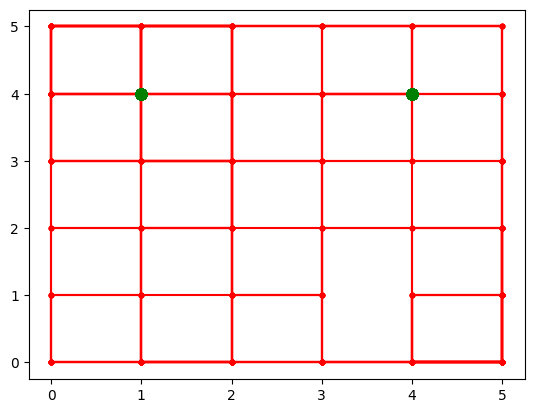

In [8]:
plt.plot(agent_df['x'], agent_df['y'], '.r-')
plt.plot(food_df['x'], food_df['y'], '.g', markersize=15)
#plt.plot(water_df['x'], water_df['y'], '.b', markersize=15)
plt.show()

<Axes: >

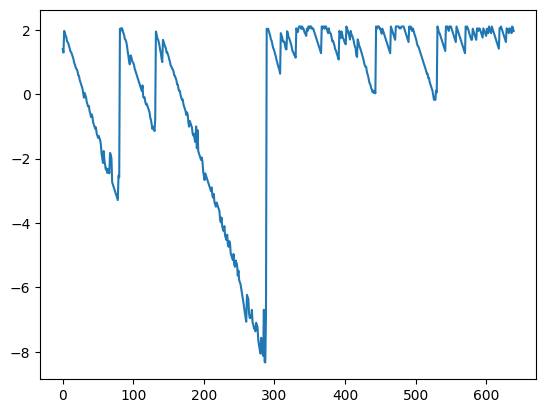

In [9]:
# plot reward received over time
df['reward'].plot()


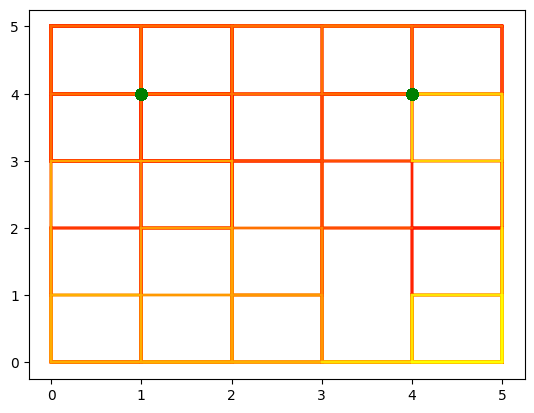

In [10]:
color_map = 'autumn' # starts yellow, goes orange, then red
n_points = len(agent_df)

fig = plt.figure()
ax1 = fig.add_subplot(111) 
cm = plt.get_cmap(color_map)
for i in range(10):
    ax1.set_prop_cycle('color', cm(np.linspace(0, 1, n_points - 1, endpoint=False)))
    for i in range(n_points - 1):
        plt.plot(agent_df['x'][i:i+2], agent_df['y'][i:i+2])
plt.plot(food_df['x'], food_df['y'], '.g', markersize=15)
#plt.plot(water_df['x'], water_df['y'], '.b', markersize=15)
plt.show()

In [11]:
# move the agent into each square and ask for its values for each action, then add that direction into the map
valuemap = np.zeros((env.metadata['map_max']+2,env.metadata['map_max']+2,4))
agent = env.agents[0]

ACTION_MAP = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]]) # This is a copy from savanna.py, should be an accessible param
for x in range(0, env.metadata['map_max']):
    for y in range(0, env.metadata['map_max']):
        if (env.grass_patches == [x,y]).all(1).any():
            continue
        if (env.water_holes == [x,y]).all(1).any():
            continue
        env.set_agent_position(agent, np.array([x,y]))
        observation = env.observe(agent)
        #print(env.agent_states[agent])
        action_vals = model(Tensor(observation)).detach().numpy()
        offset = ACTION_MAP
        for action in range(len(ACTION_MAP)):
            x_ = offset[action][0]+x
            y_ = offset[action][1]+y
            valuemap[x_,y_,action] = action_vals[action]
            
valuemap = np.sum(valuemap,2)/len(ACTION_MAP)

print(valuemap)

[[21.66617966 31.42545891 29.94578457 28.44924831  9.21249008  8.69896507
  11.06628418]
 [34.12726307 32.92529869 42.10273743 30.24423122 28.7211113   0.
  11.6951828 ]
 [11.80085564 46.4898653  33.06879807 42.57721043 20.56317139  9.946558
  12.32074451]
 [37.75024891 24.39661312 46.96843243 45.01241302 21.63766479 10.57829666
   0.        ]
 [13.11952591 38.3743372  36.98508835 23.80127716 22.84239197  0.
  13.55468369]
 [13.54415989 13.09112263 12.63526726 12.18076134  0.          0.
   0.        ]
 [10.42869186  9.89901543  9.3594389   8.81910896  8.2763319   0.
   0.        ]]


<Axes: >

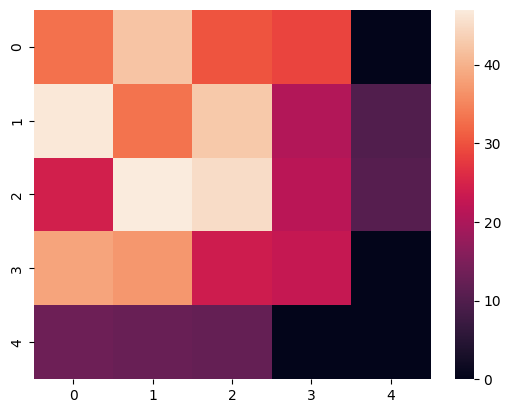

In [12]:
sns.heatmap(valuemap[1:-1,1:-1])

4.0
3.0


<Axes: >

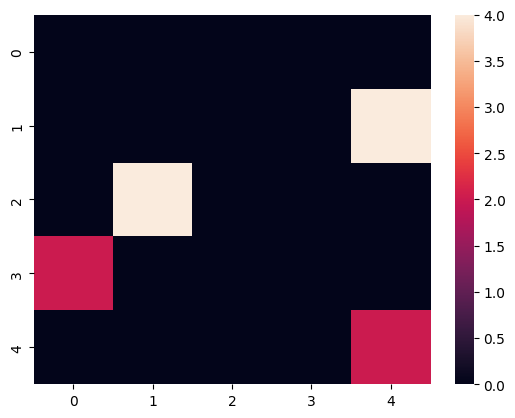

In [13]:
#env.render() isnt working atm
maps = np.zeros((env.metadata['map_max'],env.metadata['map_max']))
for grs in env.grass_patches:
    print(grs[0])
    maps[int(grs[0]),int(grs[1])] = 2.0
for wtr in env.water_holes:
    maps[int(wtr[0]),int(wtr[1])] = 4.0
sns.heatmap(maps)
# RED FOOD, LIGHT water

In [14]:
env.set_agent_position(agent, np.array([2,2]))
observation = env.observe(agent)
action_vals = model(Tensor(observation)).detach().numpy()
print(action_vals)

[43.849274 45.880943 45.711082 42.37384 ]
